## implementing the cnn model with pytorch 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')


Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU


In [7]:
# Define the CNN model
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=0)
        
        # Calculate the correct flattened size
        # Input: 32x32x3
        # After conv1 (3x3, no padding): 30x30x32
        # After pool1 (2x2): 15x15x32
        # After conv2 (3x3, no padding): 13x13x64
        # After pool2 (2x2): 6x6x64 (6.5 -> 6)
        # After conv3 (3x3, no padding): 4x4x64
        
        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 4 * 4, 64)  # Corrected: 4x4 after final conv layer
        self.fc2 = nn.Linear(64, 10)  # 10 classes for CIFAR-10
        
    def forward(self, x):
        # Conv layers with ReLU and pooling
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        # Flatten and fully connected layers
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [8]:
# Load CIFAR-10 dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, 
                                           download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, 
                                          download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
model = CNNModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"Model architecture:\n{model}")


Model architecture:
CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=1024, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [9]:
# Training function
def train_model(model, train_loader, test_loader, epochs=10):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
            
            if batch_idx % 500 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.4f}')
        
        train_accuracy = 100 * correct / total
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(train_accuracy)
        
        # Validation
        val_accuracy = evaluate_model(model, test_loader)
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {running_loss/len(train_loader):.4f}, '
              f'Train Acc: {train_accuracy:.2f}%, '
              f'Val Acc: {val_accuracy:.2f}%')
    
    return train_losses, train_accuracies, val_accuracies


In [10]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    
    accuracy = 100 * correct / total
    return accuracy

# Train the model
print("Starting training...")
train_losses, train_accuracies, val_accuracies = train_model(model, train_loader, test_loader, epochs=10)

# Final evaluation
final_accuracy = evaluate_model(model, test_loader)
print(f'\nFinal Test Accuracy: {final_accuracy:.2f}%')


Starting training...
Epoch 1/10, Batch 0, Loss: 2.2927
Epoch 1/10, Batch 500, Loss: 1.2394
Epoch 1/10, Batch 1000, Loss: 1.2157
Epoch 1/10, Batch 1500, Loss: 1.3143
Epoch 1/10: Train Loss: 1.4655, Train Acc: 46.35%, Val Acc: 55.83%
Epoch 2/10, Batch 0, Loss: 0.9512
Epoch 2/10, Batch 500, Loss: 1.0489
Epoch 2/10, Batch 1000, Loss: 0.9868
Epoch 2/10, Batch 1500, Loss: 1.0499
Epoch 2/10: Train Loss: 1.0914, Train Acc: 61.38%, Val Acc: 65.44%
Epoch 3/10, Batch 0, Loss: 0.8748
Epoch 3/10, Batch 500, Loss: 1.2337
Epoch 3/10, Batch 1000, Loss: 1.0090
Epoch 3/10, Batch 1500, Loss: 1.3981
Epoch 3/10: Train Loss: 0.9143, Train Acc: 67.83%, Val Acc: 66.81%
Epoch 4/10, Batch 0, Loss: 0.9149
Epoch 4/10, Batch 500, Loss: 0.6376
Epoch 4/10, Batch 1000, Loss: 0.7986
Epoch 4/10, Batch 1500, Loss: 0.6152
Epoch 4/10: Train Loss: 0.8098, Train Acc: 71.49%, Val Acc: 71.12%
Epoch 5/10, Batch 0, Loss: 0.9064
Epoch 5/10, Batch 500, Loss: 1.1774
Epoch 5/10, Batch 1000, Loss: 0.4471
Epoch 5/10, Batch 1500, Loss

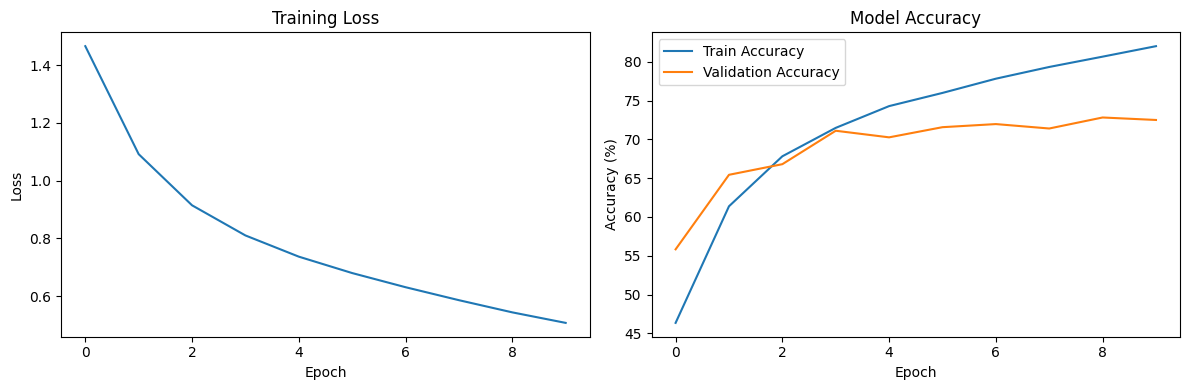

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()